#  LSTM Model - Stock Prediction

> Indented block



In [ ]:
#Importing Libraries
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
# Set the random seed for reproducibility
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [ ]:
# Read APPL.csv contains open, high, low, close, Adj close, Volume of Apple stock with twitter polarity scores and twitter volume
df = pd.read_csv('TSLA.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)

# Drop null values
df.dropna(inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
Date,,,,,,,,
2021-01-25,855.000000,900.400024,838.820007,880.799988,880.799988,41173400,0.055793,1247
2021-01-26,891.380005,895.900024,871.599976,883.090027,883.090027,23131600,0.031129,1194
2021-01-27,870.349976,891.500000,858.659973,864.159973,864.159973,27334000,0.024594,907
2021-01-28,820.000000,848.000000,801.000000,835.429993,835.429993,26378000,0.048566,528
2021-01-29,830.000000,842.409973,780.099976,793.530029,793.530029,34990800,0.105722,428


In [ ]:
# Dataframe with Adj close, ts_polarity, twitter_volume of TSLA
df = df[["Adj Close", "ts_polarity", "twitter_volume"]]
df.head()
plt.show()

In [ ]:
# percentage change based on Adj close value
df["Pct_change"] = df["Adj Close"].pct_change()

# Drop null values
df.dropna(inplace = True)
df.head()
plt.show()


### Creating the Features `X` and Target `y` Data

The first step towards preparing the data was to create the input features `X` and the target vector `y`. We used the `window_data()` function to create these vectors.

This function chunks the data up with a rolling window of _X<sub>t</sub> - window_ to predict _X<sub>t</sub>_.

The function returns two `numpy` arrays:

* `X`: The input features vectors.

* `y`: The target vector.

The function has the following parameters:

* `df`: The original DataFrame with the time series data.

* `window`: The window size in days of previous closing prices that will be used for the prediction.

* `feature_col_number`: The column number from the original DataFrame where the features are located.

* `target_col_number`: The column number from the original DataFrame where the target is located.

In [ ]:
# This function "window_data" accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    # Create empty lists "X_close", "X_polarity", "X_volume" and y
    X_close = []
    X_polarity = []
    X_volume = []
    y = []
    for i in range(len(df) - window):
        
        # Get close, ts_polarity, tw_vol, and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1]
        ts_polarity = df.iloc[i:(i + window), feature_col_number2]
        tw_vol = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        
        # Append values in the lists
        X_close.append(close)
        X_polarity.append(ts_polarity)
        X_volume.append(tw_vol)
        y.append(target)
        
    return np.hstack((X_close,X_polarity,X_volume)), np.array(y).reshape(-1, 1)

In [ ]:
# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 3

# Column index 0 is the `Adj Close` column
# Column index 1 is the `ts_polarity` column
# Column index 2 is the `twitter_volume` column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X, y = window_data(df, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

In [ ]:
# Use 80% of the data for training and the remaineder for testing
X_split = int(0.8 * len(X))
y_split = int(0.8 * len(y))

X_train = X[: X_split]
X_test = X[X_split:]
y_train = y[: y_split]
y_test = y[y_split:]

# Scaling Data with `MinMaxScaler`

We will use the `MinMaxScaler` from `sklearn` to scale all values between `0` and `1`.
Note that we scale both features and target sets.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

#the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

#Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)


[link text](https://)### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that we need to reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`.

Both sets, training, and testing are reshaped.

In [ ]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


---

## Build and Train the LSTM RNN

In this section, we designed a custom LSTM RNN and fit (train) it using the training data.

We have:
1. Defined the model architecture
2. Compiled the model
3. Fit the model to the training data

### Importing the Keras Modules

The LSTM RNN model in Keras uses the `Sequential` model, the `LSTM` layer and a `Dropout` layer.

* `Dropout`: Dropout is a regularization technique for reducing overfitting in neural networks. This type of layer applies the dropout technique to the input.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Defining the LSTM RNN Model Structure

To create an LSTM RNN model, we added `LSTM` layers. The `return_sequences` parameter needs to set to `True` every time we add a new `LSTM` layer, excluding the final layer. The `input_shape` is the number of time steps and the number of indicators

After each `LSTM` layer, we add a `Dropout` layer to prevent overfitting. The parameter passed to the `Dropout` layer is the fraction of nodes that will be drop on each epoch, for this demo, we will use a dropout value of `0.2`, it means that on each epoch we will randomly drop `20%` of the units.

The number of units in each `LSTM` layers, is equal to three times the size of the time window, we are taking three previous closing prices to predict the next closing price.

In [ ]:
# Build the LSTM model. 

# Define the LSTM RNN model.
model = Sequential()

number_units = 9
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
    
model.add(Dropout(dropout_fraction))

# Layer 2
# The return_sequences parameter needs to set to True every time we add a new LSTM layer, excluding the final layer.
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

### Compiling the LSTM RNN Model

We have compiled the model, using the `adam` optimizer, as loss function, we will use `mean_square_error` since the value we want to predict is continuous.

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 9)              396       
                                                                 
 dropout (Dropout)           (None, 9, 9)              0         
                                                                 
 lstm_1 (LSTM)               (None, 9, 9)              684       
                                                                 
 dropout_1 (Dropout)         (None, 9, 9)              0         
                                                                 
 lstm_2 (LSTM)               (None, 9)                 684       
                                                                 
 dropout_2 (Dropout)         (None, 9)                 0         
                                                                 
 dense (Dense)               (None, 1)                 1

### Training the Model

Once the model is defined, we train (fit) the model using `10` epochs. Since we are working with time-series data, it's important to set `shuffle=False` since it's necessary to keep the sequential order of the data.

We can experiment with the `batch_size` parameter; however, smaller batch size is recommended; we used `batch_size=5`.

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=1000, batch_size=200, verbose=1)

Epoch 1/1000
4/4 [==============================] - 5s 16ms/step - loss: 0.0740
Epoch 2/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0601
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0477
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0415
Epoch 5/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0373
Epoch 6/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0380
Epoch 7/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0403
Epoch 8/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0356
Epoch 9/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0359
Epoch 10/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0341
Epoch 11/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0348
Epoch 12/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0348
Epoch 13/1000
4/4 [==================

---

## Model Performance

In this section, we will evaluate the model using the test data. 

We will:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart


In [ ]:
# Evaluate the model for loss
model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 5ms/step - loss: 0.0022


0.0021794422063976526

In [ ]:
# Make some predictions
predicted = model.predict(X_test)

In [ ]:
# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

Root Mean Squared Error: 0.04668449702252395
R-squared : 0.9676307311088421


In [ ]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-06-19,200.179993,220.887726
2020-06-22,198.863998,214.516708
2020-06-23,200.356003,224.499847
2020-06-24,192.169998,225.544464
2020-06-25,197.195999,218.591110


In [ ]:
plt.show("Real vs Predicted values ")

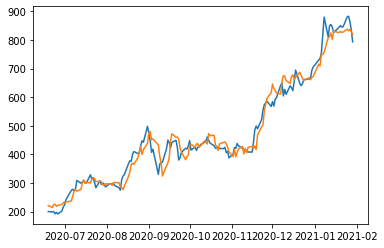

In [ ]:
plt.plot(stocks)
plt.show()

In [ ]:
# example of calculate the mean squared error
from sklearn.metrics import mean_squared_error
errors = mean_squared_error(stocks["Real"], stocks["Predicted"])
# report error
print(errors)

1041.0700453385402
